<!--NOTEBOOK_HEADER-->
This notebook contain AI based energy transition examples from [AI energy transition group](https://github.com/ShengrenHou/Energy-Data-and-Model-Platform);
content is available [on Github](https://github.com/ShengrenHou/Energy-Data-and-Model-Platform).

<!--NAVIGATION-->
< [1.1 60 Minutes to Electricity forecasting: An Dutch day ahead market electricity price forecasting example](https://ndcbe.github.io/CBE60499/01.01-Pyomo-Nuts-and-Bolts.html) 

<p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/01.02-Pyomo-Mini-Project.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/01.02-Pyomo-Mini-Project.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

### Dutch (Day Ahead Market) DAM electricity price forecasting 

Electricity price forecasting (EPF) is a branch of energy forecasting which focuses on predicting the spot and forward prices in wholesale electricity markets. Over the last 15 years electricity price forecasts have become a fundamental input to energy companies’ decision-making mechanisms at the corporate level.

In this example, two typical machine learning algorithms, i.e. Least absolute shrinkage and selection operator (LASSO) and Deep nerual network (DNN)  are implemented for the DAM electricity price forecasting based on real Dutch market data.

We develop this document based on the help of Ties. 

References:
-[Electricity price forecasting: A review of the state-of-the-art with a look into the future](https://www.sciencedirect.com/science/article/pii/S0169207014001083)

## Environment preparation 


Install [scikit-learn package](https://scikit-learn.org/stable/). 
The implemented two machine learning algorithms are imported from scikit-learn package. 


In [1]:
! pip3 install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import pickle

## Data Prepartion 


### Data download and read 

Download data from our [github](https://github.com/ShengrenHou/Energy-Data-and-Model-Platform) link

In [4]:
!git clone https://github.com/ShengrenHou/Energy-Data-and-Model-Platform

Cloning into 'Energy-Data-and-Model-Platform'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 54 (delta 8), reused 44 (delta 1), pack-reused 0
Unpacking objects: 100% (54/54), done.


Read csv data as pandas dataframe and use the first column as the index (time index)

In [5]:
data=pd.read_csv('./Energy-Data-and-Model-Platform/Data/NL.csv',index_col=0,parse_dates=True,)
data

,Price,Load
2015-01-01 00:00:00+01:00,NaN,9794.00
2015-01-01 01:00:00+01:00,NaN,9456.00
2015-01-01 02:00:00+01:00,NaN,8956.75
2015-01-01 03:00:00+01:00,NaN,8461.50
2015-01-01 04:00:00+01:00,NaN,8156.00
...,...,...
2019-12-31 19:00:00+01:00,46.00,13517.25
2019-12-31 20:00:00+01:00,42.20,12799.25
2019-12-31 21:00:00+01:00,39.74,12064.25
2019-12-31 22:00:00+01:00,38.88,11641.25


Tansfer data index as datetime based on pandas fuunction.

In [6]:
data.index=pd.to_datetime(data.index,yearfirst=True,utc=True,format='%Y-%m-%d %H:%M:%S')
print(data.index)
print(type(data.index))
print(data.index.hour)
print(data.index.year)


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Int64Index([23,  0,  1,  2,  3,  4,  5,  6,  7,  8,
            ...
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
           dtype='int64', length=43824)
Int64Index([2014, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', length=43824)


Rearrange data, so we have daily indices with hourly values in the columns 


In [ ]:
grouped_prices = data.loc[:, ['Price']].groupby(data.index.hour)
daily_prices = pd.DataFrame(index=data.loc[data.index.hour==0].index, columns=range(24), data={h: grouped_prices.get_group(h).values.flatten() for h in range(24)})

In [ ]:
grouped_load = data.loc[:, ['Load']].groupby(data.index.hour)
daily_load = pd.DataFrame(index=data.loc[data.index.hour==0].index, columns=range(24), data={h: grouped_load.get_group(h).values.flatten() for h in range(24)})

Make a feature dataframe with lagged loads and prices. We include the data of the last three days, and the same day last week (d-1, d-2, d-3, d-7)


In [ ]:
lags = [1, 2, 3, 7]

X = pd.concat([daily_prices.shift(l) for l in lags] + [daily_load.shift(l) for l in lags], axis=1).astype(float)
X.columns = [f'P_{h}_{l}' for l in lags for h in range(24)] + [f'L_{h}_{l}' for l in lags for h in range(24)]

Now add the day of the week as a feature. We make a difference for the LASSO (linear model) and the Neural Network (non-linear model). LASSO needs one-hot encoding for these features, while the neural network can deal with a single weekday column having integers representing days.

In [ ]:
X_lasso = X.copy()
for d in range(7):
    X_lasso.loc[X_lasso.index.weekday==d, f'D_{d}']=1
    X_lasso.loc[X_lasso.index.weekday!=d, f'D_{d}']=0

In [ ]:
X_mlp = X.copy()
X_mlp.loc[:, 'DOW'] = X_mlp.index.weekday

In [ ]:
X_lasso.dropna(inplace=True)
X_mlp.dropna(inplace=True)

y = daily_prices.loc[(daily_prices.index.isin(X_lasso.index)) & (daily_prices.index.isin(X_mlp.index))]

Split the data in train-test sets. We use 2019 as test set and the rest as training set. For the lasso we use a different model per hour, and use a single train-test split where we decide the lasso-coefficient on the training data only.

In [ ]:
def lasso_cols(h):
    return [f'P_{h}_{l}' for l in lags] + [f'L_{h}_{l}' for l in lags] + [f'D_{d}' for d in range(7)]

test_years = [2019]#[2018, 2019]

Xdict_lasso = {
    h: {
        'train': X_lasso.loc[~(X_lasso.index.year.isin(test_years)), lasso_cols(h)],
        'test': X_lasso.loc[(X_lasso.index.year.isin(test_years)), lasso_cols(h)] 
    } for h in range(24)
}

ydict_lasso = {
    h: {
        'train': y.loc[~(y.index.year.isin(test_years)), h],
        'test': y.loc[(y.index.year.isin(test_years)), h]
    } for h in range(24)
}

Xdict_mlp = {
    'train': X_mlp.loc[~(X_mlp.index.year.isin(test_years))],
    'test': X_mlp.loc[(X_mlp.index.year.isin(test_years))]
}

ydict_mlp = {
    'train': y.loc[~(y.index.year.isin(test_years))],
    'test': y.loc[(y.index.year.isin(test_years))]
}

Fit a Z-score standard scaler to the feature training set.

In [ ]:
scaler_lasso = {h: StandardScaler().fit(Xdict_lasso[h]['train']) for h in range(24)}
scaler_mlp = StandardScaler().fit(Xdict_mlp['train'])

## Train and evaluate by LASSO

[Least absolute shrinkage and selection operator (LASSO)](https://www.jstor.org/stable/2346178#metadata_info_tab_contents), is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model.

Lasso was originally formulated for linear regression models. This simple case reveals a substantial amount about the estimator. These include its relationship to ridge regression and best subset selection and the connections between lasso coefficient estimates and so-called soft thresholding. It also reveals that (like standard linear regression) the coefficient estimates do not need to be unique if covariates are collinear.

In this part, LASSO is implemented to train the price forecast model.

### Optimizing the LASSo 

Make a handy iterable for the cross-validation, this way we can split the sets by year instead of random.

In [ ]:
y_t = ydict_lasso[0]['train']
ind_df = pd.DataFrame(index=y_t.index, data={'idx': range(len(y_t.index))})
cv = [ (ind_df.loc[ind_df.index.year!=year, 'idx'].values, ind_df.loc[ind_df.index.year==year, 'idx'].values) for year in range(2015, 2019)]

For the LASSO we train a single model per hour of the day. So we need to optimise 24 penalty coefficients.

In [ ]:
LassoCV_dict={
    h: LassoCV(cv=cv).fit(X=scaler_lasso[h].transform(Xdict_lasso[h]['train']), y=ydict_lasso[h]['train'].values) for h in tqdm(range(24))
}

  0%|          | 0/24 [00:00<?, ?it/s]

We extract the optimised penalty coefficients.

In [ ]:
alphas = {
    h: LassoCV_dict[h].alpha_ for h in range(24)
}

Now we refit the models on the whole training data with the optimised penalty coefficients.

In [ ]:
lasso_dict = {
    h: Lasso(alpha=alphas[h]).fit(X=scaler_lasso[h].transform(Xdict_lasso[h]['train']), y=ydict_lasso[h]['train'].values) for h in tqdm(range(24))
}

  0%|          | 0/24 [00:00<?, ?it/s]

### Forecasting with LASSO 


In [ ]:
lasso_fc = pd.DataFrame(index=ydict_mlp['test'].index, data={h: lasso_dict[h].predict(scaler_lasso[h].transform(Xdict_lasso[h]['test'])) for h in range(24)}).round(2)

In [ ]:
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

def plot_forecast(date, fcdf, ax=None):
    flag=False
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,2))
        flag=True
        
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    
    plotind=pd.date_range(date, freq='1H', periods=24)
    
    ax.step(plotind, daily_prices.loc[date, :].values, color='k', label='DAM price')
    ax.step(plotind, fcdf.loc[date, :].values, color='C0', label='Forecast')
    
    ax.set_xlim(plotind[0], plotind[-1])

    ax.set_ylabel('Price [$€ MWh^{-1}$]')
    
    
    if flag:
        ax.legend(loc='best')
        

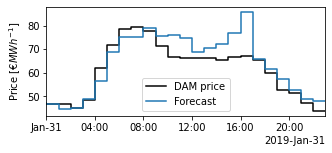

In [ ]:
day_nr=30
plot_forecast(lasso_fc.index[day_nr], lasso_fc)

## Training and forecasting for the DNNs 

A DNN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. DNNs have been widely used on load forecasting problems.

We create the network with two hidden layers, first layer with 100 nodes and the second with 50 nodes. The nodes use the ReLU activation function, and the Adam optimiser is applied. We also apply early stopping, so we keep track of the loss on a validation set to know when to stop training.

Reference: 
- [Wiki](https://en.wikipedia.org/wiki/Energy_forecasting)


In [ ]:
MLP = MLPRegressor(
    hidden_layer_sizes=(100,50),
    activation='relu',
    solver='adam',
    validation_fraction=0.2,
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=1000
).fit(
    X=scaler_mlp.transform(Xdict_mlp['train']),
    y=ydict_mlp['train'].values
)

In [ ]:
mlp_fc = pd.DataFrame(index=ydict_mlp['test'].index, columns=range(24))
mlp_fc.loc[:,:] = MLP.predict(scaler_mlp.transform(Xdict_mlp['test']))

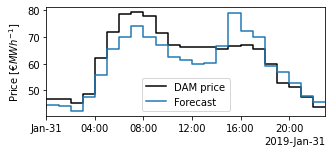

In [ ]:
day_nr=30
plot_forecast(mlp_fc.index[day_nr], mlp_fc)

## Evaluate the trained two models 

We evaluate the performance of trained two algorithms by root mean square error (RMSE), mean eroor (ME) and absolute mean error (MAE). 

Reference: 
- [data science paper](https://towardsdatascience.com/comparing-robustness-of-mae-mse-and-rmse-6d69da870828)

In [ ]:
def MAE(fcdf):
    return (fcdf-ydict_mlp['test']).abs().mean().mean()

def ME(fcdf):
    return (fcdf-ydict_mlp['test']).mean().mean()

def RMSE(fcdf):
    return np.sqrt(((fcdf-ydict_mlp['test'])**2).mean().mean())

In [ ]:
stats = pd.DataFrame(index=['MAE', 'ME', 'RMSE'], columns=['LASSO', 'MLP'], dtype=float)
stats.loc['MAE', :] = [MAE(lasso_fc), MAE(mlp_fc)]
stats.loc['ME', :] = [ME(lasso_fc), ME(mlp_fc)]
stats.loc['RMSE', :] = [RMSE(lasso_fc), RMSE(mlp_fc)]

stats.round(2)

,LASSO,MLP
MAE,4.56,7.89
ME,0.30,5.10
RMSE,6.24,9.92
